# Midterm CS506

These are the packages we need to get started

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('./data/train.csv')
df.head()

,Id,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,0005019281,ADZPIG9QOCDG5,0,0,4.0,1203984000,good version of a classic,This is a charming version of the classic Dick...
1,1,0005019281,A35947ZP82G7JH,0,0,3.0,1388361600,Good but not as moving,It was good but not as emotionally moving as t...
2,2,0005019281,A3UORV8A9D5L2E,0,0,3.0,1388361600,Winkler's Performance was ok at best!,"Don't get me wrong, Winkler is a wonderful cha..."
3,3,0005019281,A1VKW06X1O2X7V,0,0,5.0,1202860800,It's an enjoyable twist on the classic story,Henry Winkler is very good in this twist on th...
4,4,0005019281,A3R27T4HADWFFJ,0,0,4.0,1387670400,Best Scrooge yet,This is one of the best Scrooge movies out. H...


## Data Analysis

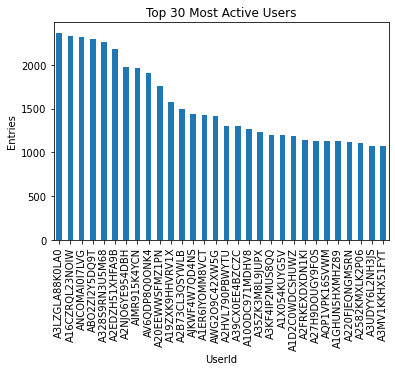

In [3]:

# TODO

df['UserId'].value_counts(sort=True, ascending=False).iloc[:30].plot.bar()
plt.title('Top 30 Most Active Users')
plt.xlabel('UserId')
plt.ylabel('Entries')
plt.show()

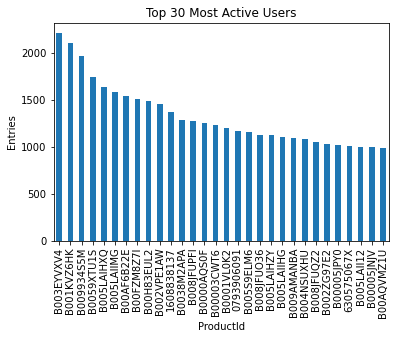

In [4]:
df['ProductId'].value_counts(sort=True, ascending=False).iloc[:30].plot.bar()
plt.title('Top 30 Most Active Users')
plt.xlabel('ProductId')
plt.ylabel('Entries')
plt.show()

In [5]:

# TODO

In [6]:

# TODO


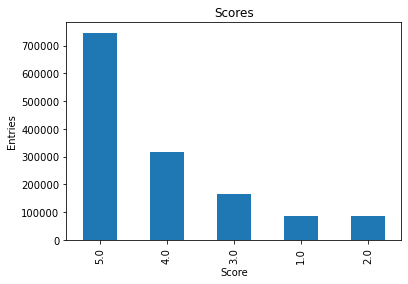

In [7]:
df['Score'].value_counts().plot.bar()
plt.title('Scores')
plt.xlabel('Score')
plt.ylabel('Entries')
plt.show()

In [8]:
# TODO


## Missing Values

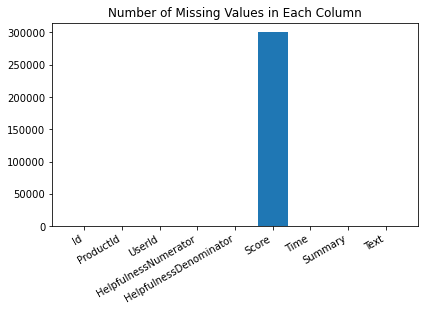

In [9]:
# TODO
missingValues = {}
for col in df.columns:
    missingValues[col] = df[col].isna().sum()

fig = plt.figure()
plt.bar(missingValues.keys(), missingValues.values())
plt.title('Number of Missing Values in Each Column')
plt.xticks(rotation=45, )
plt.tight_layout()
fig.autofmt_xdate()
plt.show()

In [10]:
# TODO


## Preprocessing

Downsize the entries with score = 5.0, to reduce the bias of the model.

In [11]:
df = pd.concat(
    [df.loc[df['Score'] != 5], df.loc[df['Score'] == 5].sample(frac=0.5)])

Encode the UserId and ProductId fields

In [12]:
encodedIds = OneHotEncoder(sparse=True).fit_transform(
    df[['UserId', 'ProductId']])

...

In [13]:
df['Helpful'] = df['HelpfulnessNumerator']
df['Unhelpful'] = df['HelpfulnessDenominator'] - df['HelpfulnessNumerator']
df[['Helpful', 'Unhelpful', 'Time'
    ]] = StandardScaler().fit_transform(df[['Helpful', 'Unhelpful', 'Time']])

df = df.drop(['HelpfulnessDenominator', 'HelpfulnessNumerator'], axis=1)

other = scipy.sparse.csr_matrix(df[['Helpful', 'Unhelpful', 'Time']].values)

In [15]:
df['Summary'].fillna('', inplace=True)
df['Text'].fillna('', inplace=True)

tfidf = TfidfVectorizer(stop_words='english')
text = tfidf.fit_transform(df['Text'])
summary = tfidf.fit_transform(df['Summary'])

Stack all of the transformed features together into a single matrix

In [16]:
X = scipy.sparse.hstack([encodedIds, other, summary, text])
X_sparse = scipy.sparse.csr_matrix(X)

In [17]:
test = df['Score'].isna()

trainIdx, testIdx = (~test).to_numpy().nonzero()[0], test.to_numpy().nonzero()[0]

X_train = scipy.sparse.csr_matrix(X)[trainIdx]
X_test = scipy.sparse.csr_matrix(X)[testIdx]

Y_train = df.reset_index()['Score']

print(X_train.shape, Y_train.shape)

(1024273, 967793)


## Model Evaluation

In [18]:
model = LogisticRegression(random_state=0).fit(X_train, Y_train)
Y_pred = model.predict(X_train)
print('Training Accuracy:', mean_squared_error(Y_pred, Y_train))

/Users/ivan/opt/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy: 0.6861071218317772


In [19]:
submission = pd.read_csv('./data/test.csv')

submission['Score'] = model.predict(X_test)
submission.to_csv('./data/submission.csv', index=False)